In [33]:
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

from matplotlib.pyplot import figure
import plotly.graph_objects as go

In [39]:
# set paths to dirs in data dir

path_data_dir = os.path.join(os.getcwd(), "data")

path_dialogs_meta_dir = os.path.join(path_data_dir, "dialogs_list")
path_dialogs_dir = os.path.join(path_data_dir, "dialogs")

path_to_dialogs_info = f"{path_data_dir}/all_dialogs_by_type.json"

USER_ID = 331192040

In [24]:
dialogs_info = {
    "Private dialog": {},
    "Group": {},
    "Channel": {}
}

# make dialogs_info dict: first level keys - "Channel", "Private dialog", "Group"
# second level items - "<name_of_dialog>": <id>
for file in os.listdir(path_dialogs_meta_dir):
    if file[-4:] == "json":
        with open(os.path.join(path_dialogs_meta_dir, file), "r", encoding="utf8") as meta_file:
            data = json.load(meta_file)

        dialogs_info[data["type"]][data["name"]] = data["id"]

# 1) save results
with open(path_to_dialogs_info, "w", encoding="utf-8") as f:
    json.dump(dialogs_info, f, indent=4, ensure_ascii=False)

## Plot of daily activity (09.08.2020)

In [36]:
# TODO: write such functions is a antipattern. 
# such code is a spagetti code
# you should: 1. decompose it on the simpler methods, 2. move all constants as (40 + 30) to the variables and comment logic behind them

def get_user_activity(dialogs_info, date_before, date_after, dialog_type, user_id_get_msg,
                      plot_type="daily_activity"):
    """

    :param dialogs_info: dict: first level keys - "Channel", "Private dialog", "Group"
    second level items - "<name_of_dialog>": <id>
    :param date_before: datetime type, from what time start to analyse msgs
    :param date_after: datetime type, to what time to analyse msgs
    :param dialog_type: "Channel" or "Private dialog" or "Group"
    :param plot_type: plot name for which you prepare your data
    :return: lists for a plot of "top_friends" or "daily_activity", depends on
    your input plot_type
    """
    dialog_active_minutes = 0

    plot_data = {}
    if plot_type == "daily_activity":
        for hour in range(24):
            if hour < 10:
                hour = '0' + str(hour)
                plot_data[hour] = 0
            else:
                plot_data[str(hour)] = 0

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        start_dialog_time, stop_dialog_time = 0, 0
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            print(dialog_id)
            continue

        dialog_data = pd.read_csv("data/dialogs/{}.csv".format(dialog_id))
        dialog_active_minutes_before = dialog_active_minutes
        flag_first_my_message = 0
        
        for row in dialog_data.index:
            if dialog_data["from_id"][row] == user_id_get_msg:

                date_time = dialog_data["date"][row][:-6]
                dialog_datetime = datetime.datetime.strptime(date_time,"%Y-%m-%d %H:%M:%S")
                
                # get previous message time for plot of "active_minutes" - number of minutes spending on
                # conversations during a day
                if flag_first_my_message == 0:
                    previous_message_time = dialog_datetime
                    flag_first_my_message = 1

                if dialog_datetime <= date_before:
                    break

                elif date_before < dialog_datetime < date_after:
                    if plot_type == "daily_activity":
                        our_local_time = int(dialog_data['date'][row][11:13]) + 2
                        if our_local_time < 10:
                            our_local_time = "0" + str(our_local_time)
                            
                        else:
                            our_local_time = str(our_local_time)
                                
                        plot_data[our_local_time] += 1

                    elif plot_type == "top_friends":
                        plot_data[friend] = plot_data.get(friend, 0) + 1

                    elif plot_type == "active_minutes":
                        time_before_my_messages = previous_message_time - dialog_datetime
                        try:
                            if dialog_data["from_id"][row + 1] == user_id_get_msg and \
                                    time_before_my_messages.total_seconds() < 600:
                                previous_message_time = dialog_datetime
                                if stop_dialog_time == 0:
                                    stop_dialog_time = dialog_datetime

                            else:
                                if stop_dialog_time == 0:
                                    dialog_active_minutes += 15
                                else:
                                    start_dialog_time = dialog_datetime
                                    time_since = stop_dialog_time - start_dialog_time
                                    if time_since.total_seconds() >= 600:
                                        time_since = stop_dialog_time - previous_message_time
                                        dialog_active_minutes += time_since.total_seconds() + 40 + 30

                                    else:
                                        # add 40 sec - time for reading + writing first message
                                        dialog_active_minutes += time_since.total_seconds() + 40

                                previous_message_time = dialog_datetime
                                start_dialog_time, stop_dialog_time = 0, 0

                        except KeyError as error:
                            print("KEYERROR!!!", error)

        if plot_type == "active_minutes":
            print("Time spend on conversation: dialog {} {} minutes".format(friend,
                                                                            (dialog_active_minutes - dialog_active_minutes_before) // 60))

    if plot_type == "active_minutes":
        # add 5 minutes in case of unpredictable situations
        return dialog_active_minutes // 60 + 5

    x, y = "", ""
    lists = []
    if plot_type == "daily_activity":
        lists = sorted(plot_data.items())
        x, y = zip(*lists)
    elif plot_type == "top_friends":
        lists = {k: v for k, v in sorted(plot_data.items(), key=lambda item: item[1], reverse=True)}

    return x, y, lists

KeyError: '24'

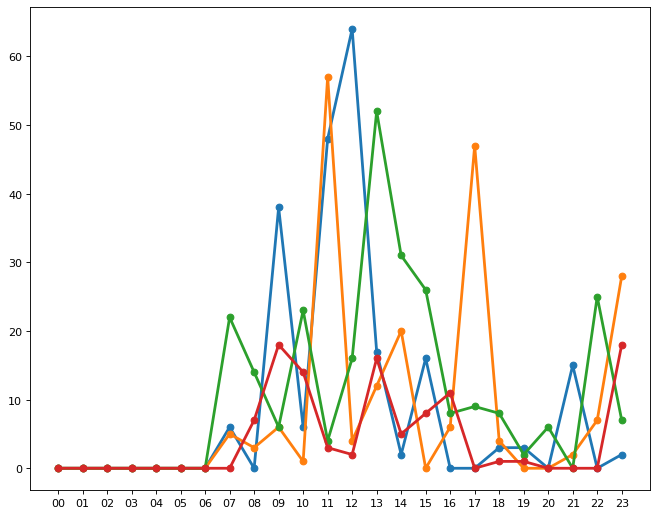

In [46]:
# TODO: 1. add some explanation to the plot: title, labels for axises, maybe legend. Now it tells nothing
# TODO: 2. fix KeyError: '24'


figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
fig = go.Figure()

for i in range(7):
    date_before = datetime.datetime(2020, 8, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID)

    fig.add_trace(go.Bar(
        y=x,
        x=y,
        name="{}-08-2020".format(4 + i),
        orientation='h',
        marker=dict(
            line=dict(color='rgb(105, 105, 105, 1.0)', width=3)
        )
    ))
    plt.plot(x, y, linewidth=2.5, marker='o', linestyle="-", label="{}-08-2020".format(4 + i))

plt.xticks([i for i in range(0, 24)])
plt.legend(loc='upper left', frameon=False)
plt.show()

# show comparing bar
fig.update_layout(
    barmode='stack',
    autosize=False,
    width=800,
    height=800,
    yaxis = dict(
            title='Hours',
            titlefont_size=16,
            tickfont_size=14,
            tickmode = 'array',
            tickvals = [i for i in range(24)]),
    xaxis = dict(
            title='Number of messages',
            titlefont_size=16,
            tickfont_size=14)
)
fig.show()

## Top people with whom communicate during 10.06.2020 - 09.08.2020

In [48]:
# TODO: are these recived messages? or sent? can you pls give statistics for both(sent and recived). store this in the dataframe

date_before = datetime.datetime(2017, 1, 10, 0, 0, 0)
date_after = datetime.datetime(2020, 8, 10, 0, 0, 0)

x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID, "top_friends")
for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

1 place is Andrew Kurochkin with 883 messages
2 place is Anastasia Mazur with 674 messages
3 place is Саша Уку with 672 messages
4 place is Макс Шк with 667 messages
5 place is Вітя Перукар with 650 messages
6 place is Констянтин Бохан with 639 messages
7 place is Тарасон Ліпший with 617 messages
8 place is Роман Мойсеєв with 611 messages
9 place is Богдан Матвіїв with 606 messages
10 place is Олег Камера with 598 messages
11 place is Anastasia Khaburska with 587 messages
12 place is Олексій with 576 messages
13 place is Юля with 567 messages
14 place is Oleh UCU with 562 messages
15 place is Олег Онищак with 562 messages
16 place is Гроцький Д with 561 messages
17 place is Андрій Романчак with 558 messages
18 place is Ярема Сірський with 546 messages
19 place is Ivan Prodaiko with 544 messages
20 place is Кукуруз with 544 messages
21 place is Саша Датасайнс with 542 messages
22 place is Саша Чепурной with 531 messages
23 place is Olena Shevchenko with 528 messages
24 place is Артем Іс

In [ ]:
# TODO: add same calculations for number of words. add it to the same dataframe

## Top groups with whom communicate during 10.06.2020 - 09.08.2020

In [44]:
x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Group", USER_ID, "top_friends")

for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

1 place is секретний чат with 497 messages
2 place is rasta420 with 490 messages
3 place is ds18+ with 355 messages
4 place is curilca_UCU with 311 messages
5 place is Карантинна чвертка з Олею with 142 messages
6 place is Дизайн Карпатська with 128 messages
7 place is A&S&P(&A) 13/05 with 87 messages
8 place is F12 with 85 messages
9 place is lohika_ucu with 77 messages
10 place is пятничні двіжа with 76 messages
11 place is tmp with 71 messages
12 place is d2v with 65 messages
13 place is 12/05 Ph&A flat with 58 messages
14 place is П'ятниця 🍺🍺🍺 with 40 messages
15 place is SunPhoto with 35 messages
16 place is Modern & Concept photography ONLINE (summer 2020) with 31 messages
17 place is ід картка with 23 messages
18 place is text_review with 22 messages
19 place is KT with 19 messages
20 place is ООА with 16 messages
21 place is Карантинна чвертка with 16 messages
22 place is Ґайзуни with 10 messages
23 place is AP&A with 10 messages
24 place is Шашлик на Гвардійській with 9 messag

## Time spending on conversations during 03.08.2020 - 09.08.2020

KEYERROR!!! 88
Time spend on conversation: dialog Controller Bot 11.0 minutes
Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog Тадік Вітін 10.0 minutes
Time spend on conversation: dialog Андрій Сабініч 0.0 minutes
Time spend on conversation: dialog Анфиса Краса и Сказочные Чудеса 0.0 minutes
Time spend on conversation: dialog Anton 0.0 minutes
Time spend on conversation: dialog Anton Shcherbyna 37.0 minutes
Time spend on conversation: dialog Лєвий 0.0 minutes
KEYERROR!!! 106
Time spend on conversation: dialog Богдана Микитюк 16.0 minutes
KEYERROR!!! 35
Time spend on conversation: dialog Степан Єрошенка 6.0 minutes
Time spend on conversation: dialog Олесь Уку 21.0 minutes
Time spend on conversation: dialog Андрій Запотічний 0.0 minutes
Time spend on conversation: dialog ПриватБанкБот 0.0 minutes
Time spend on conversation: dialog Настя Хома 0.0 minutes
KEYERROR!!! 123
Time spend on conversation: dialog Roman 20.0 minutes
KEYERROR!!! 1000
Time spend on c

KEYERROR!!! 163
Time spend on conversation: dialog Yulia Dov 35.0 minutes
Time spend on conversation: dialog Алексей Зал 148.0 minutes
Time spend on conversation: dialog Maxym 0.0 minutes
Time spend on conversation: dialog Diana Nikitina 62.0 minutes
KEYERROR!!! 180
Time spend on conversation: dialog Тарас Дизайн 21.0 minutes
Time spend on conversation: dialog Юля 236.0 minutes
Time spend on conversation: dialog Serhii Tiutiunnyk 2.0 minutes
Time spend on conversation: dialog Anastasiia 0.0 minutes
Time spend on conversation: dialog Куратор Король 0.0 minutes
Time spend on conversation: dialog Андрій ЄБРР 0.0 minutes
Time spend on conversation: dialog Вастрик 0.0 minutes
Time spend on conversation: dialog Женя Тараса 0.0 minutes
KEYERROR!!! 277
Time spend on conversation: dialog Нася Кучерява 57.0 minutes
Time spend on conversation: dialog europrice 0.0 minutes
Time spend on conversation: dialog Sasha Lozinskyi 8.0 minutes
Time spend on conversation: dialog Лена Хата 0.0 minutes
Time s

Time spend on conversation: dialog B-Day Trip 31.05-03.06 0.0 minutes
Time spend on conversation: dialog П'ятниця 🍺🍺🍺 11.0 minutes
Time spend on conversation: dialog перекурщики Киев 0.0 minutes
Time spend on conversation: dialog 123 0.0 minutes
Time spend on conversation: dialog lohika_ucu 29.0 minutes
KEYERROR!!! 2
Time spend on conversation: dialog XXX Morning@Lohika 04.04.2020 0.0 minutes
Time spend on conversation: dialog Heralds of Spring 0.0 minutes
Time spend on conversation: dialog Finance Project [UCU] 0.0 minutes
Time spend on conversation: dialog SunPhoto 0.0 minutes
Time spend on conversation: dialog ds18+ 103.0 minutes
Time spend on conversation: dialog Ахуєвший двіж в АК на базі, після НР 0.0 minutes
Time spend on conversation: dialog подарок 0.0 minutes
Time spend on conversation: dialog Morning @ Lohika(26/01/2019) 0.0 minutes
Time spend on conversation: dialog Morning B-thday #5 0.0 minutes
KEYERROR!!! 21
Time spend on conversation: dialog AP&A 1.0 minutes
Time spend 

Time spend on conversation: dialog Андрій Димоходи 0.0 minutes
Time spend on conversation: dialog Olha Hnativ 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Olha N 157.0 minutes
Time spend on conversation: dialog Микола Максименко 10.0 minutes
Time spend on conversation: dialog Наталя УКУ 0.0 minutes
Time spend on conversation: dialog Mykola Kolinko 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Саша Уку 215.0 minutes
Time spend on conversation: dialog Munim ahmed ( Freelance Web & Software developer) 0.0 minutes
KEYERROR!!! 155
Time spend on conversation: dialog Дарко Рецент 28.0 minutes
Time spend on conversation: dialog Nazar Pawliuk 0.0 minutes
Time spend on conversation: dialog Lingvo 0.0 minutes
Time spend on conversation: dialog Felix Uber 0.0 minutes
Time spend on conversation: dialog Chekachkov academy 4.0 minutes
Time spend on conversation: dialog Олег Онищак 35.0 minutes
Time spend on conversation: dialog Olena Shevchenko 24.0 minutes
Time s

Time spend on conversation: dialog Ґайзуни 2.0 minutes
Time spend on conversation: dialog Пражский вечер 0.0 minutes
Time spend on conversation: dialog y 0.0 minutes
Time spend on conversation: dialog Sax 0.0 minutes
Time spend on conversation: dialog ДН Олега 0.0 minutes
Time spend on conversation: dialog Подарунок Саничу 0.0 minutes
Time spend on conversation: dialog ід картка 6.0 minutes
Time spend on conversation: dialog Monday: beer and good talks 0.0 minutes
KEYERROR!!! 110
Time spend on conversation: dialog 12/05 Ph&A flat 27.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog секретний чат 197.0 minutes
KEYERROR!!! 167
Time spend on conversation: dialog пятничні двіжа 21.0 minutes
Time spend on conversation: dialog Box&MJ 0.0 minutes
Time spend on conversation: dialog 18.05.19 студентське життя 2.0 0.0 minutes
Time spend on conversation: dialog 3 літні квіточки 0.0 minutes
KEYERROR!!! 131
Time spend on conversation: dialog tmp 21.0 minutes
Time spend on conversation: 

Time spend on conversation: dialog Олег Камера 170.0 minutes
Time spend on conversation: dialog Вероніка Староста 0.0 minutes
Time spend on conversation: dialog Vadym Korshunov 0.0 minutes
Time spend on conversation: dialog Паря 0.0 minutes
KEYERROR!!! 2
Time spend on conversation: dialog Max Ostrozhinskiy 0.0 minutes
Time spend on conversation: dialog Yuriy Lizak 0.0 minutes
Time spend on conversation: dialog Helga K 6.0 minutes
Time spend on conversation: dialog Y ΨRII ΨΞLιSIE I-3V 0.0 minutes
Time spend on conversation: dialog Лісапєд Тьома 0.0 minutes
Time spend on conversation: dialog Віталій Колега 8.0 minutes
Time spend on conversation: dialog roma cayman 0.0 minutes
Time spend on conversation: dialog Andrii 7.0 minutes
Time spend on conversation: dialog Олександр Парубій 18.0 minutes
Time spend on conversation: dialog Андрій Ревін 7.0 minutes
Time spend on conversation: dialog Іван Вергун 0.0 minutes
Time spend on conversation: dialog Philipp Kofman 120.0 minutes
Time spend on 

Time spend on conversation: dialog Тарасон Ліпший 18.0 minutes
Time spend on conversation: dialog Олексій Карзов 1.0 minutes
Time spend on conversation: dialog Вова Лун 0.0 minutes
Time spend on conversation: dialog Vitalii 1.0 minutes
Time spend on conversation: dialog Ігор Банадіга 23.0 minutes
Time spend on conversation: dialog Олексій Музикант 0.0 minutes
Time spend on conversation: dialog Valerii 0.0 minutes
Time spend on conversation: dialog Volodymyr Kondratenko RLR COO 0.0 minutes
Time spend on conversation: dialog Теодор УКУ 0.0 minutes
Time spend on conversation: dialog Фотоврамке 1.0 minutes
Time spend on conversation: dialog Dmytro Babenko 6.0 minutes
Time spend on conversation: dialog Nazarii Nyzhnyk 0.0 minutes
Time spend on conversation: dialog Соломія 0.0 minutes
KEYERROR!!! 47
Time spend on conversation: dialog Соля Гнідець (Логіка) 9.0 minutes
Time spend on conversation: dialog Марія Кавальєр 0.0 minutes
Time spend on conversation: dialog Tarik Freeman 0.0 minutes
KEY

Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog Тадік Вітін 10.0 minutes
Time spend on conversation: dialog Андрій Сабініч 0.0 minutes
Time spend on conversation: dialog Анфиса Краса и Сказочные Чудеса 0.0 minutes
Time spend on conversation: dialog Anton 0.0 minutes
Time spend on conversation: dialog Anton Shcherbyna 37.0 minutes
Time spend on conversation: dialog Лєвий 0.0 minutes
KEYERROR!!! 106
Time spend on conversation: dialog Богдана Микитюк 16.0 minutes
KEYERROR!!! 35
Time spend on conversation: dialog Степан Єрошенка 6.0 minutes
Time spend on conversation: dialog Олесь Уку 21.0 minutes
Time spend on conversation: dialog Андрій Запотічний 0.0 minutes
Time spend on conversation: dialog ПриватБанкБот 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Настя Хома 77.0 minutes
KEYERROR!!! 123
Time spend on conversation: dialog Roman 20.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Oleh UCU 181.0 minutes
Time spend on con

Time spend on conversation: dialog Oleg Dats 3.0 minutes
KEYERROR!!! 31
Time spend on conversation: dialog Mary 4.0 minutes
Time spend on conversation: dialog Modest 0.0 minutes
Time spend on conversation: dialog Vlad 0.0 minutes
Time spend on conversation: dialog Вова Логіка 24.0 minutes
KEYERROR!!! 39
Time spend on conversation: dialog Роман Родич ІТ аутсорс 4.0 minutes
Time spend on conversation: dialog Serge Bishyr 15.0 minutes
Time spend on conversation: dialog Гогі Київ 0.0 minutes
Time spend on conversation: dialog Anton Mi 0.0 minutes
Time spend on conversation: dialog Костя Датасайн 44.0 minutes
Time spend on conversation: dialog Yuliia 0.0 minutes
Time spend on conversation: dialog Danylo Kolinko 0.0 minutes
Time spend on conversation: dialog Serhii Brodiuk 0.0 minutes
Time spend on conversation: dialog Oleksii Boiko 0.0 minutes
Time spend on conversation: dialog Ann Karachevska 7.0 minutes
Time spend on conversation: dialog Вітя Перукар 185.0 minutes
KEYERROR!!! 6
Time spend

Time spend on conversation: dialog d2v 9.0 minutes
Time spend on conversation: dialog Movies 🍿 0.0 minutes
Time spend on conversation: dialog Паті на хаті 0.0 minutes
Time spend on conversation: dialog Київ Львів 0.0 minutes
Time spend on conversation: dialog Бурса, 43пз 0.0 minutes
Time spend on conversation: dialog MMDS trenders 0.0 minutes
Time spend on conversation: dialog Goodfellas 0.0 minutes
Time spend on conversation: dialog The boys and the girls 0.0 minutes
Time spend on conversation: dialog Бокс 0.0 minutes
Time spend on conversation: dialog OUR NEXT TRIP 0.0 minutes
Time spend on conversation: dialog Карантинна чвертка з Олею 43.0 minutes
Time spend on conversation: dialog Карантинна чвертка 4.0 minutes
Time spend on conversation: dialog Kiev organic weekend 0.0 minutes
KEYERROR!!! 4
Time spend on conversation: dialog AK film [dev] 0.0 minutes
Time spend on conversation: dialog B-Day Trip 31.05-03.06 0.0 minutes
Time spend on conversation: dialog П'ятниця 🍺🍺🍺 11.0 minutes


KEYERROR!!! 1000
Time spend on conversation: dialog Olha N 157.0 minutes
Time spend on conversation: dialog Микола Максименко 10.0 minutes
Time spend on conversation: dialog Наталя УКУ 0.0 minutes
Time spend on conversation: dialog Mykola Kolinko 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Саша Уку 215.0 minutes
Time spend on conversation: dialog Munim ahmed ( Freelance Web & Software developer) 0.0 minutes
KEYERROR!!! 155
Time spend on conversation: dialog Дарко Рецент 28.0 minutes
Time spend on conversation: dialog Nazar Pawliuk 0.0 minutes
Time spend on conversation: dialog Lingvo 0.0 minutes
Time spend on conversation: dialog Felix Uber 0.0 minutes
Time spend on conversation: dialog Chekachkov academy 4.0 minutes
Time spend on conversation: dialog Олег Онищак 35.0 minutes
Time spend on conversation: dialog Olena Shevchenko 24.0 minutes
Time spend on conversation: dialog Anna Nortsova 6.0 minutes
Time spend on conversation: dialog Yaroslava Lochman 20.0 minutes
K

Time spend on conversation: dialog 3 літні квіточки 0.0 minutes
KEYERROR!!! 131
Time spend on conversation: dialog tmp 21.0 minutes
Time spend on conversation: dialog Ярко подарок, кіслота_247 0.0 minutes
KEYERROR!!! 24
Time spend on conversation: dialog ООА 3.0 minutes
Time spend on conversation: dialog Шоколадний Пакєтік 0.0 minutes
KEYERROR!!! 6
Time spend on conversation: dialog Lv:v F:lm People 2.0 minutes
Time spend on conversation: dialog Berlin weed crusade 0.0 minutes
Time spend on conversation: dialog Party in the zoo 0.0 minutes
Time spend on conversation: dialog "I am the gift" 0.0 minutes
Time spend on conversation: dialog APPS@UCU (всі) ❤️ 0.0 minutes
Time spend on conversation: dialog UCUKyiv 0.0 minutes
Time spend on conversation: dialog ODS: AskMeAnything 0.0 minutes
Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog top performers 0.0 minutes
Time spend on conversation: dialog Fender CD-60 S & Обмивон 0.0 minutes
Time spend on conversat

KEYERROR!!! 1000
Time spend on conversation: dialog Гроцький Д 172.0 minutes
KEYERROR!!! 16
Time spend on conversation: dialog Дана Іщук 🔥 1.0 minutes
Time spend on conversation: dialog Олексій WIX 0.0 minutes
KEYERROR!!! 33
Time spend on conversation: dialog УКРПОШТА 1.0 minutes
KEYERROR!!! 234
Time spend on conversation: dialog Юля Тіндер 58.0 minutes
Time spend on conversation: dialog Андрій Романчак 0.0 minutes
Time spend on conversation: dialog Мар'яна Романишин 9.0 minutes
Time spend on conversation: dialog L 0.0 minutes
Time spend on conversation: dialog Настя Ніка 0.0 minutes
Time spend on conversation: dialog Dmytro Shylov 2.0 minutes
Time spend on conversation: dialog Андрон Малий 0.0 minutes
Time spend on conversation: dialog Anton Skrypnyk 0.0 minutes
Time spend on conversation: dialog Bob Marley 0.0 minutes
Time spend on conversation: dialog Жека Поздняков 51.0 minutes
Time spend on conversation: dialog Леся Сусідка Філатова 0.0 minutes
Time spend on conversation: dialog f

Time spend on conversation: dialog Женя Айо 68.0 minutes
Time spend on conversation: dialog Sophie Pashko 0.0 minutes
Time spend on conversation: dialog Христя 4.0 minutes
Time spend on conversation: dialog Олена Музика УКУ 0.0 minutes
Time spend on conversation: dialog Саша Датасайнс 67.0 minutes
KEYERROR!!! 19
Time spend on conversation: dialog 1319botDev 1.0 minutes
KEYERROR!!! 27
Time spend on conversation: dialog Dasha Vishniveckaya 4.0 minutes
Time spend on conversation: dialog 🚬 Курильщики 0 minutes
Time spend on conversation: dialog Нова назва групи 0 minutes
Time spend on conversation: dialog L.420 0 minutes
Time spend on conversation: dialog 23.09.1996 0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog curilca_UCU 106.0 minutes
KEYERROR!!! 172
Time spend on conversation: dialog F12 23.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog rasta420 159.0 minutes
Time spend on conversation: dialog Soccer-UCU 0.0 minutes
Time spend on conversation: dialog Math 

Time spend on conversation: dialog Богдан Матвіїв 206.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Роман Мойсеєв 172.0 minutes
Time spend on conversation: dialog Tonia Chundak 1.0 minutes
Time spend on conversation: dialog Anton Parfeniuk 0.0 minutes
Time spend on conversation: dialog Тарас Матяшовський 0.0 minutes
Time spend on conversation: dialog HashTag 0.0 minutes
Time spend on conversation: dialog Олексій 183.0 minutes
Time spend on conversation: dialog Oleg Khromov 0.0 minutes
Time spend on conversation: dialog Млинко 0.0 minutes
Time spend on conversation: dialog Andriy Gazin 0.0 minutes
KEYERROR!!! 102
Time spend on conversation: dialog BotFather 12.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Anastasia Khaburska 222.0 minutes
Time spend on conversation: dialog Ivan Prodaiko 84.0 minutes
Time spend on conversation: dialog Марина Логіканка 0.0 minutes
Time spend on conversation: dialog Ivan Hladkyi 0.0 minutes
Time spend on conversation: dialog

Time spend on conversation: dialog Юля 236.0 minutes
Time spend on conversation: dialog Serhii Tiutiunnyk 0.0 minutes
Time spend on conversation: dialog Anastasiia 0.0 minutes
Time spend on conversation: dialog Куратор Король 0.0 minutes
Time spend on conversation: dialog Андрій ЄБРР 0.0 minutes
Time spend on conversation: dialog Вастрик 0.0 minutes
Time spend on conversation: dialog Женя Тараса 0.0 minutes
KEYERROR!!! 277
Time spend on conversation: dialog Нася Кучерява 57.0 minutes
Time spend on conversation: dialog europrice 0.0 minutes
Time spend on conversation: dialog Sasha Lozinskyi 8.0 minutes
Time spend on conversation: dialog Лена Хата 0.0 minutes
Time spend on conversation: dialog Нік 175.0 minutes
Time spend on conversation: dialog Макс Шк 72.0 minutes
Time spend on conversation: dialog Вова Офіс 0.0 minutes
Time spend on conversation: dialog Alexander Kataev 0.0 minutes
Time spend on conversation: dialog Ярко Фвлевич 86.0 minutes
KEYERROR!!! 23
Time spend on conversation: 

Time spend on conversation: dialog d2v 23.0 minutes
Time spend on conversation: dialog Movies 🍿 0.0 minutes
Time spend on conversation: dialog Паті на хаті 0.0 minutes
Time spend on conversation: dialog Київ Львів 0.0 minutes
Time spend on conversation: dialog Бурса, 43пз 0.0 minutes
Time spend on conversation: dialog MMDS trenders 0.0 minutes
Time spend on conversation: dialog Goodfellas 0.0 minutes
Time spend on conversation: dialog The boys and the girls 0.0 minutes
Time spend on conversation: dialog Бокс 0.0 minutes
Time spend on conversation: dialog OUR NEXT TRIP 0.0 minutes
Time spend on conversation: dialog Карантинна чвертка з Олею 43.0 minutes
Time spend on conversation: dialog Карантинна чвертка 4.0 minutes
Time spend on conversation: dialog Kiev organic weekend 0.0 minutes
KEYERROR!!! 4
Time spend on conversation: dialog AK film [dev] 0.0 minutes
Time spend on conversation: dialog B-Day Trip 31.05-03.06 0.0 minutes
Time spend on conversation: dialog П'ятниця 🍺🍺🍺 11.0 minutes

<Figure size 1280x1120 with 0 Axes>

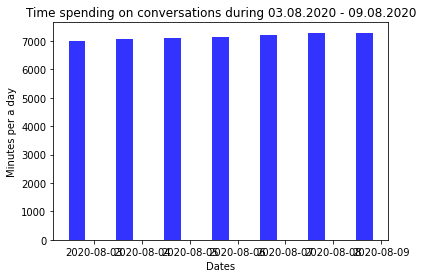

In [52]:
# TODO: it's not okay to have so mane KEYERROR!!!s, something in the logic is wrong
# table with time spend on the dialog should be in the dataframe
# when I dwar chart for long time period(7 months) I see same bars, with values 7000minutes per day, are you sure it's okay?
    
plot_data = {}
for i in range(7):
    date_before = datetime.datetime(2020, 1, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    general_dialog_time = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID, "active_minutes") \
                          + get_user_activity(dialogs_info, date_before, date_after, "Group", USER_ID, "active_minutes")
    plot_data[datetime.date(2020, 8, 3 + i)] = general_dialog_time

print(plot_data)
lists = sorted(plot_data.items())
dates, n_minutes_lst = zip(*lists)

n_days = 7

# create plot
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots()
index = np.arange(n_days)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, n_minutes_lst, bar_width,
alpha=opacity,
color='b')

plt.xlabel('Dates')
plt.ylabel('Minutes per a day')
plt.title('Time spending on conversations during 03.08.2020 - 09.08.2020')
plt.xticks(index + bar_width, dates)

plt.show()